In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import * 

# IV skew 的统计分析

## 1. IV Skew 的本质  

- **隐含波动率曲线（IV Curve）**：同一到期日、不同执行价的期权，其隐含波动率通常会随着执行价高低而有系统性变化──这就是 IV 曲线。  
- **整体 Skew（Slope）**：把执行价的对数偏离度 $\log(K/S)$（log-moneyness）当自变量，IV 做线性回归，回归斜率即整体 Skew。  
- **局部 Skew（Local Skew 或 Skew per Step）**：用相邻档位的 IV 差分近似导出数值，更聚焦于每个 strike 附近的斜度。

---

## 2. 用 ATM 基准和步长计算 `skew_per_step`  

1. **确定 ATM**  
   - 每分钟（及每个到期日）选出最接近底层价格 $S$ 的执行价 $K_{\rm atm}$，并取其 IV 为 $\text{IV}_{\rm atm}$。  
2. **量化步长**  
   - CF 合约的最小行权价步长是 200 点。  
   - 定义  
     $$
       \Delta_\text{steps} = \frac{K - K_{\rm atm}}{200}
     $$
3. **局部偏度**  
   - 对每一行  
     $$
       \text{skew\_per\_step} \;=\;
       \frac{\text{IV}(K) - \text{IV}_{\rm atm}}{\Delta_\text{steps}}
       \quad(\Delta_\text{steps}\neq0)
     $$
   - ATM 档位 $\Delta_\text{steps}=0$ 时，可将 `skew_per_step` 设为 NaN。

---

## 3. 滚动分位数：捕捉 “异常” Skew  

我们要知道在历史同档位下，这个 `skew_per_step` 正常分布在哪里，然后当前值落在某个极端分位就发信号。

1. **按档位分组**  
   $$
     \text{for each }\;d\in\{\dots,-2,-1,1,2,\dots\}:\;
     X_{d,t} = \bigl\{\text{skew\_per\_step}(t') \mid \Delta_\text{steps}=d,\;t'\le t\}
   $$
2. **滑动窗口**  
   - 用过去 $W$ 条记录（或过往 $D$ 交易日同一分钟点的样本）做窗口。  
   - 窗口大小建议：$W\approx3\text{天}\times240\text{分钟}=720$条，或按分钟数直接定 $W$。  
3. **计算 quantile**  
   - 对每组 $X_{d,t}$ 维护  
     $
       q_{d,t}^{\alpha} = \operatorname{Quantile}\bigl(X_{d,t},\,\alpha\bigr)
     $
   - 常用 $\alpha=0.90,0.95$（做 Put Spread）、$\alpha=0.10,0.05$（做 Call Spread）。
4. **信号触发**  
   - **做多 Put Spread**（捕捉恐慌过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}>q^{0.90}_{d,t}
     $$
   - **做多 Call Spread**（捕捉乐观过度）：  
     $$
       \text{if }\;\text{skew\_per\_step}_{t}<q^{0.10}_{d,t}
     $$

---

## 4. 实践要点与优化  

- **最低档位筛选**：一般跳过 $|\Delta_\text{steps}|<2$的档位，过滤流动性差、噪声大的近 ATM 档。  
- **最少样本期**：window 内至少保留 $\min\_periods$个样本（例如 1000 条）再开始计算 quantile，避免极端失真。  
- **平滑处理**：如信号过于抖动，可对 `skew_per_step` 做短窗口（3–5 分钟） rolling mean，再比较分位数。  
- **信号冷却**：一旦同档位触发信号，设置几分钟内不重复进场，防止高频震荡。  
- **止盈止损**：例如 skew 回归至历史中位数（50% 分位）时平仓，或达到固定持有分钟数后强制平仓。  
- **回测验证**：  
  1. 在历史分钟线数据上模拟开／平仓，记录 P&L 曲线、胜率、Sharpe。  
  2. 网格搜索 $\{\alpha\in[0.90,0.95],\,W\in[2000,10000],\,|\Delta_\text{steps}|\ge2\}$ 等参数组合。  

---

### 小结

- **核心指标**：`skew_per_step = (IV - IV_atm)/Δsteps`，反映相对于 ATM 的局部斜度。  
- **信号逻辑**：基于每个档位 `skew_per_step` 的历史滚动分位极值，判断“偏高”或“偏低”再做对应价差。  
- **关键落地**：窗口期 $W$、分位度 $\alpha$、档位筛选、平滑与冷却等参数都需回测验证才能定下来。



## 初始化

In [2]:
path="opt_test_data/SR_options_data.parquet"
size=100
CF=Option_strat(path,size)

In [3]:
df=CF.read_df(path)

In [4]:
df

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T
0,2024-06-03 20:59,SR2409P6300,207.500000,181.500000,3630.0,2.0,1142.0,False,6300.0,70.0,6213.500000,194.500000,181.500000,2024-06-03,2024-06-03 20:59:00,0.277778
1,2024-06-03 21:00,SR2409C6300,111.897436,107.589744,66280.0,60.0,5008.0,True,6300.0,70.0,6216.705128,109.743590,108.307692,2024-06-03,2024-06-03 21:00:00,0.277778
2,2024-06-03 21:00,SR2409C6400,80.438596,78.447368,49830.0,63.0,6312.0,True,6400.0,70.0,6217.000000,79.442982,79.508772,2024-06-03,2024-06-03 21:00:00,0.277778
3,2024-06-03 21:00,SR2409C6500,58.850000,57.050000,32160.0,56.0,13098.0,True,6500.0,70.0,6216.608333,57.950000,57.983333,2024-06-03,2024-06-03 21:00:00,0.277778
4,2024-06-03 21:00,SR2409C6600,44.515625,43.625000,163865.0,371.0,31775.0,True,6600.0,70.0,6217.151042,44.070312,43.994792,2024-06-03,2024-06-03 21:00:00,0.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435122,2024-08-14 23:00,SR2501P5400,66.000000,57.000000,562535.0,950.0,3410.0,False,5400.0,118.0,5659.500000,61.500000,60.500000,2024-08-14,2024-08-14 23:00:00,0.468254
435123,2024-08-14 23:00,SR2501P5500,90.000000,78.000000,512360.0,597.0,2844.0,False,5500.0,118.0,5659.500000,84.000000,88.000000,2024-08-14,2024-08-14 23:00:00,0.468254
435124,2024-08-14 23:00,SR2501P5600,128.000000,90.000000,699775.0,579.0,7147.0,False,5600.0,118.0,5659.500000,109.000000,126.500000,2024-08-14,2024-08-14 23:00:00,0.468254
435125,2024-08-14 23:00,SR2501P5700,175.500000,80.500000,650265.0,390.0,3307.0,False,5700.0,118.0,5659.500000,128.000000,172.000000,2024-08-14,2024-08-14 23:00:00,0.468254


### 计算iv

In [5]:
df_iv=CF.add_iv(df)

#### 同一strike，平均化iv

In [6]:
df_iv=CF.ave_iv(df_iv)

In [7]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean
0,2024-06-03 20:59,SR2409P6300,207.500000,181.500000,3630.0,2.0,1142.0,False,6300.0,70.0,6213.500000,194.500000,181.500000,2024-06-03,2024-06-03 20:59:00,0.277778,0.111929,0.111929
1,2024-06-03 21:00,SR2409C6300,111.897436,107.589744,66280.0,60.0,5008.0,True,6300.0,70.0,6216.705128,109.743590,108.307692,2024-06-03,2024-06-03 21:00:00,0.277778,0.112237,0.113197
2,2024-06-03 21:00,SR2409C6400,80.438596,78.447368,49830.0,63.0,6312.0,True,6400.0,70.0,6217.000000,79.442982,79.508772,2024-06-03,2024-06-03 21:00:00,0.277778,0.116089,0.116089
3,2024-06-03 21:00,SR2409C6500,58.850000,57.050000,32160.0,56.0,13098.0,True,6500.0,70.0,6216.608333,57.950000,57.983333,2024-06-03,2024-06-03 21:00:00,0.277778,0.120951,0.120951
4,2024-06-03 21:00,SR2409C6600,44.515625,43.625000,163865.0,371.0,31775.0,True,6600.0,70.0,6217.151042,44.070312,43.994792,2024-06-03,2024-06-03 21:00:00,0.277778,0.127498,0.127498
5,2024-06-03 21:00,SR2409C6700,33.000000,31.250000,3250.0,10.0,10710.0,True,6700.0,70.0,6215.500000,32.125000,32.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.132034,0.132034
6,2024-06-03 21:00,SR2409C7000,19.000000,17.000000,380.0,2.0,10037.0,True,7000.0,70.0,6216.928571,18.000000,19.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.155854,0.155854
7,2024-06-03 21:00,SR2409C7300,12.000000,9.500000,115.0,1.0,1678.0,True,7300.0,70.0,6215.500000,10.750000,11.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.176758,0.176758
8,2024-06-03 21:00,SR2409C7500,11.133333,10.500000,14895.0,139.0,25774.0,True,7500.0,70.0,6215.400000,10.816667,10.633333,2024-06-03,2024-06-03 21:00:00,0.277778,0.200299,0.200299
9,2024-06-03 21:00,SR2409P5400,9.000000,8.500000,875.0,10.0,3263.0,False,5400.0,70.0,6217.384615,8.750000,8.807692,2024-06-03,2024-06-03 21:00:00,0.277778,0.157209,0.157209


In [8]:
df_iv=CF.get_underly_F(df_iv)

In [9]:
df_iv.head(30)

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,underly_mean_mid,mean_mid,twap,date_str,minute,T,iv,iv_mean,underly_F
0,2024-06-03 20:59,SR2409P6300,207.500000,181.500000,3630.0,2.0,1142.0,False,6300.0,70.0,6213.500000,194.500000,181.500000,2024-06-03,2024-06-03 20:59:00,0.277778,0.111929,0.111929,6214
1,2024-06-03 21:00,SR2409C6300,111.897436,107.589744,66280.0,60.0,5008.0,True,6300.0,70.0,6216.705128,109.743590,108.307692,2024-06-03,2024-06-03 21:00:00,0.277778,0.112237,0.113197,6216
2,2024-06-03 21:00,SR2409C6400,80.438596,78.447368,49830.0,63.0,6312.0,True,6400.0,70.0,6217.000000,79.442982,79.508772,2024-06-03,2024-06-03 21:00:00,0.277778,0.116089,0.116089,6216
3,2024-06-03 21:00,SR2409C6500,58.850000,57.050000,32160.0,56.0,13098.0,True,6500.0,70.0,6216.608333,57.950000,57.983333,2024-06-03,2024-06-03 21:00:00,0.277778,0.120951,0.120951,6216
4,2024-06-03 21:00,SR2409C6600,44.515625,43.625000,163865.0,371.0,31775.0,True,6600.0,70.0,6217.151042,44.070312,43.994792,2024-06-03,2024-06-03 21:00:00,0.277778,0.127498,0.127498,6216
5,2024-06-03 21:00,SR2409C6700,33.000000,31.250000,3250.0,10.0,10710.0,True,6700.0,70.0,6215.500000,32.125000,32.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.132034,0.132034,6216
6,2024-06-03 21:00,SR2409C7000,19.000000,17.000000,380.0,2.0,10037.0,True,7000.0,70.0,6216.928571,18.000000,19.000000,2024-06-03,2024-06-03 21:00:00,0.277778,0.155854,0.155854,6216
7,2024-06-03 21:00,SR2409C7300,12.000000,9.500000,115.0,1.0,1678.0,True,7300.0,70.0,6215.500000,10.750000,11.500000,2024-06-03,2024-06-03 21:00:00,0.277778,0.176758,0.176758,6216
8,2024-06-03 21:00,SR2409C7500,11.133333,10.500000,14895.0,139.0,25774.0,True,7500.0,70.0,6215.400000,10.816667,10.633333,2024-06-03,2024-06-03 21:00:00,0.277778,0.200299,0.200299,6216
9,2024-06-03 21:00,SR2409P5400,9.000000,8.500000,875.0,10.0,3263.0,False,5400.0,70.0,6217.384615,8.750000,8.807692,2024-06-03,2024-06-03 21:00:00,0.277778,0.157209,0.157209,6217


### 确定ATM strike，计算local skew

* 选择ATM iv，根据200的价差去计算skew，这样统计分位数，也方便去交易。

* 其实到了这一步，可以去构建vol surface，看是否有 non-convex 套利的机会

In [10]:
df_skew=CF.get_local_skew(df_iv)

In [11]:
df_skew

,minute_str,Instrument,mean_ask,mean_bid,cumcashvol,cumvolume,openinterest,is_call,strike,maturity,...,date_str,minute,T,iv,iv_mean,underly_F,strike_atm,iv_atm,strike_diff_steps,skew_per_step
0,2024-06-03 20:59,SR2409P6300,207.50,181.500000,3630.0,2.0,1142.0,False,6300.0,70.0,...,2024-06-03,2024-06-03 20:59:00,0.277778,0.111929,0.111929,6214,6300.0,0.111929,0,NaN
1,2024-06-03 21:00,SR2409P5400,9.00,8.500000,875.0,10.0,3263.0,False,5400.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.157209,0.157209,6217,6300.0,0.114156,-9,-0.004784
2,2024-06-03 21:00,SR2409P5500,12.50,12.000000,4375.0,35.0,9460.0,False,5500.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.150274,0.150274,6217,6300.0,0.114156,-8,-0.004515
3,2024-06-03 21:00,SR2409P5600,16.00,15.333333,625.0,4.0,3925.0,False,5600.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.140457,0.140457,6217,6300.0,0.114156,-7,-0.003757
4,2024-06-03 21:00,SR2409P5700,23.75,20.562500,215.0,1.0,4870.0,False,5700.0,70.0,...,2024-06-03,2024-06-03 21:00:00,0.277778,0.133939,0.133939,6217,6300.0,0.114156,-6,-0.003297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435122,2024-08-14 23:00,SR2501C6300,25.00,10.500000,61945.0,547.0,13040.0,True,6300.0,118.0,...,2024-08-14,2024-08-14 23:00:00,0.468254,0.113513,0.113513,5660,5700.0,0.084828,6,0.004781
435123,2024-08-14 23:00,SR2501C6400,12.00,7.500000,25995.0,322.0,17810.0,True,6400.0,118.0,...,2024-08-14,2024-08-14 23:00:00,0.468254,0.110074,0.110074,5660,5700.0,0.084828,7,0.003607
435124,2024-08-14 23:00,SR2501C6500,8.50,6.500000,10800.0,166.0,2822.0,True,6500.0,118.0,...,2024-08-14,2024-08-14 23:00:00,0.468254,0.114903,0.114903,5660,5700.0,0.084828,8,0.003759
435125,2024-08-14 23:00,SR2501C6800,6.50,4.000000,680.0,15.0,2353.0,True,6800.0,118.0,...,2024-08-14,2024-08-14 23:00:00,0.468254,0.135926,0.135926,5660,5700.0,0.084828,11,0.004645


#### ATM iv 可视化


In [12]:
atm_iv=CF.get_atm_iv(df_skew)

<Axes: xlabel='minute'>

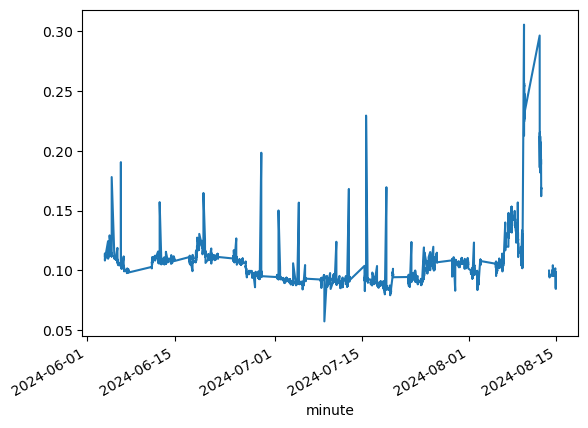

In [13]:
atm_iv.iv_atm.plot()

**ATM IV trading**:

* 第一，检测并确认是否需要过滤掉outliers。
* 第二，可以直接计算rolling quantile交易ATM IV。
* 第三，可以对ATM IV运用时间序列分析或者预测，比如 LSTM，去预测IV。

不过此次分析不在此方向展开，主要研究local skew。

#### 可视化skew统计性质

* 确定是否有均值回归现象。
* 确定哪些diff step 存在比较明显的均值回归。
* 确定均值回归的平均时间（半衰期）。

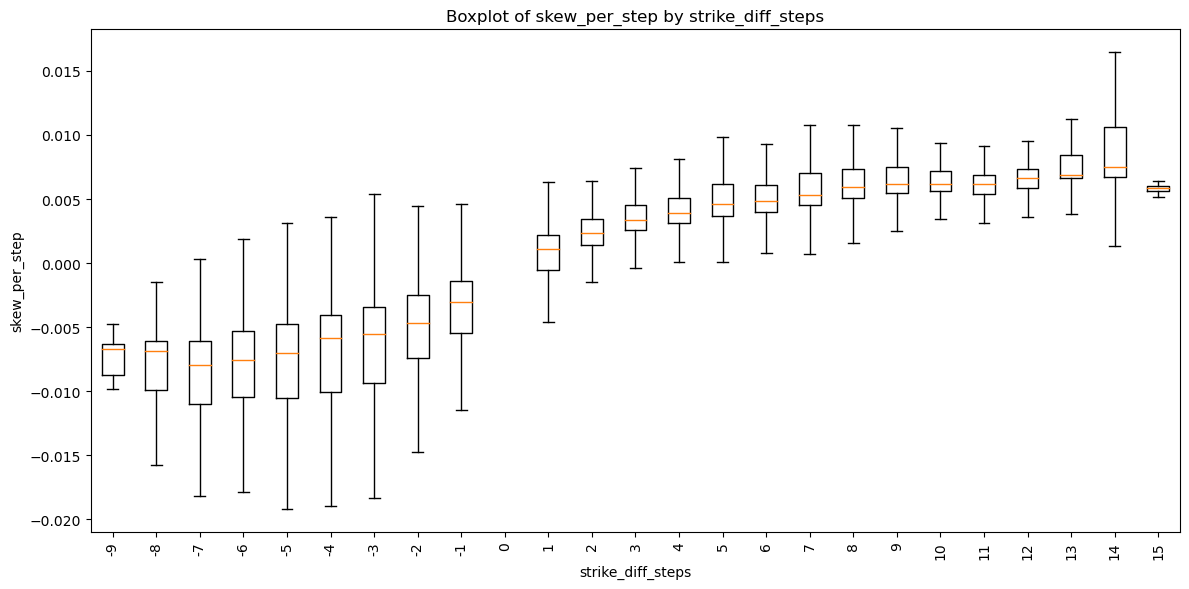

In [14]:
CF.plot_box(df_skew)

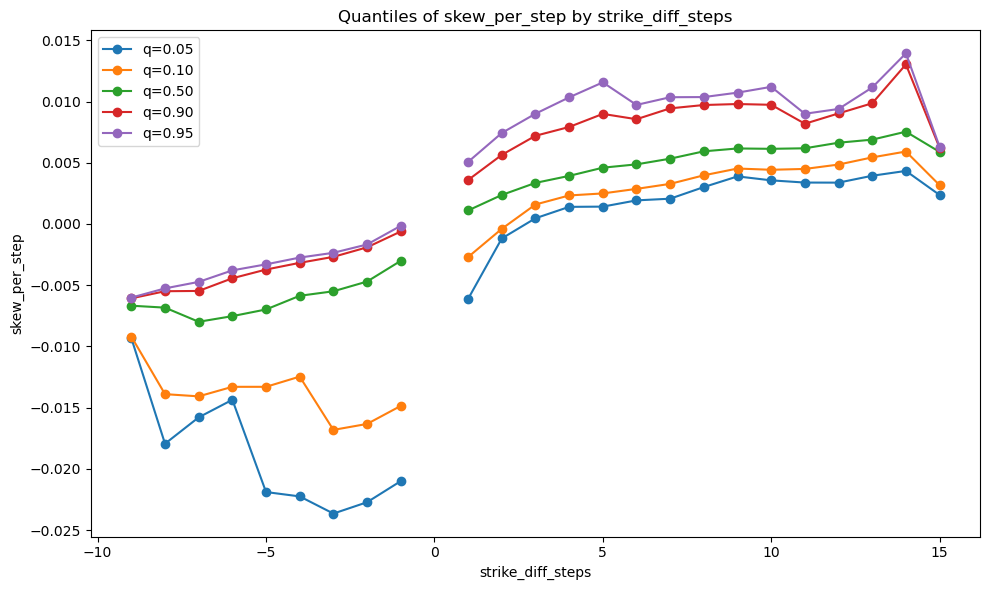

In [15]:
CF.plot_quantile(df_skew)

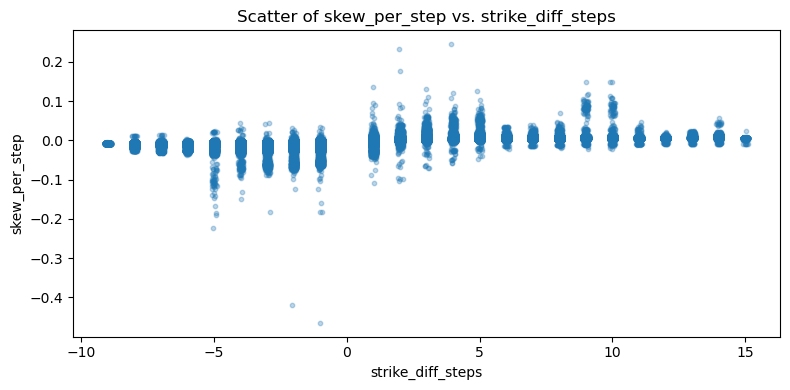

In [16]:
CF.plot_scatter(df_skew)

In [17]:
CF_sig=Signals([0.1,0.9])

In [18]:
events_df=CF_sig.get_signals(df_skew)

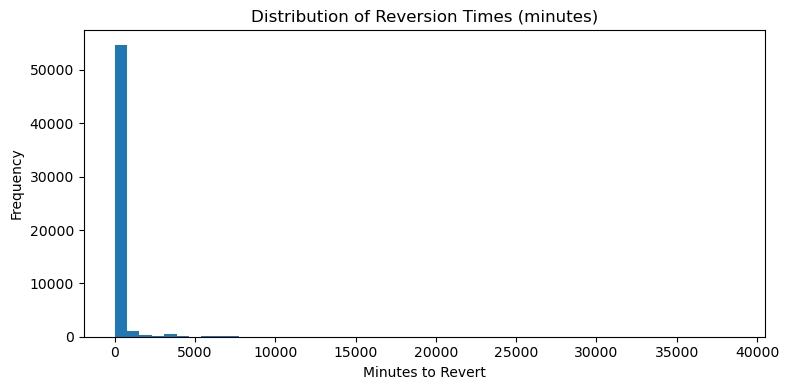

<Figure size 1000x400 with 0 Axes>

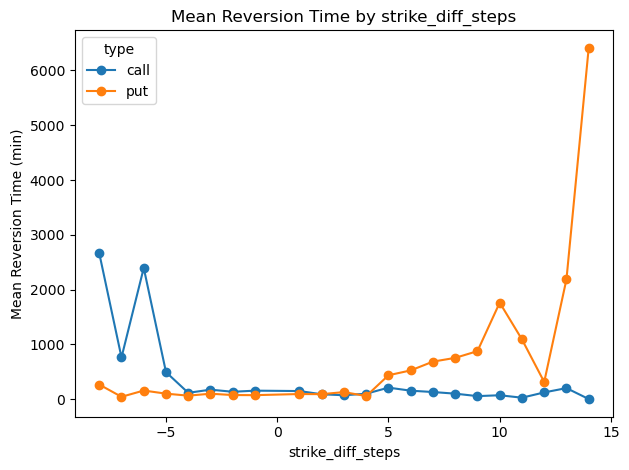

Overall mean reversion times (min):
type
call    194.099199
put     221.406108
Name: dt, dtype: float64


In [19]:
events_df,agg=CF_sig.plot(events_df)

In [20]:
agg

type,call,put
steps,,
-8,2664.694915,266.835979
-7,761.461364,42.980447
-6,2395.588235,157.574969
-5,493.432432,100.497955
-4,115.867925,63.926497
-3,173.393911,99.475403
-2,134.953243,75.106177
-1,155.228739,73.041030
1,148.045266,93.659083


#### 结论

* 选择step size 从-5，到10.
* 选择qunatile0.05和0.95作为入场信号，quantile 0.5 作为平仓信号。

### 回测

In [21]:
df = df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True)


In [22]:
CF.bact_test(df)

总笔数： 11362
总 PnL： -108313.18622608404
平均单笔 PnL： -9.532933130266153
胜率： 0.02050695300123218
      count       mean           sum        std
type                                           
call   6142  -4.576607 -28109.519120  19.265135
put    5220 -15.364687 -80203.667106  44.713057
       count       mean
steps                  
-1      2248 -10.583336
 2      3753  -8.428093
 3      2796 -12.235577
 4      1354  -7.729840
 5       587  -5.013295
 6       447  -5.526478
 7       177 -15.825963


提高quantile阈值，减少交易频率。

In [23]:
CF.bact_test(df_skew.sort_values(['strike_diff_steps', 'minute']).reset_index(drop=True),quantile=[0.02,0.98])

总笔数： 5741
总 PnL： -73684.04938274367
平均单笔 PnL： -12.834706389608723
胜率： 0.01776693955756837
      count       mean           sum        std
type                                           
call   3069  -5.789168 -17766.955370  25.106405
put    2672 -20.927056 -55917.094013  55.172691
       count       mean
steps                  
-1      1054 -14.664361
 2      2003 -11.002782
 3      1434 -14.660236
 4       619 -15.875772
 5       293  -6.496917
 6       235  -5.830697
 7       103 -20.053864


对于白糖期权而言，看起来step 5，6上可以优化，考虑双边ask-bid价差，离盈利挺近了。